In [1]:
import sys
from os.path import join, abspath
from glob import glob
import numpy as np
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
from time import time
from scipy.optimize import curve_fit
from scipy.stats import norm, skewnorm

In [2]:
root_dir = abspath(join('..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
# import utils
from utils import style, hdi, load_spectral_types
style(name="seaborn-notebook")

In [4]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [5]:
df_spec = load_spectral_types()
df_spec

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [6]:
data_baryon_dir = join(root_data_dir, "Baryon")
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

In [7]:
boundaries = np.load(join(root_data_dir, "boundaries.npy"))
boundaries = boundaries[:15]

In [8]:
c_low = boundaries[:, 0]
c_high = boundaries[:, 1]
c = (c_low + c_high) / 2
dc = c_high-c_low
c, dc

(array([0.05250143, 0.15600191, 0.20350107, 0.23000178, 0.25000142,
        0.26700073, 0.28150205, 0.29400182, 0.30600122, 0.3175022 ,
        0.3280024 , 0.33800223, 0.34800205, 0.35750149, 0.36900051]),
 array([0.14300287, 0.06399808, 0.03100024, 0.02200119, 0.0179981 ,
        0.0160005 , 0.01300213, 0.01199742, 0.01200136, 0.01100059,
        0.00999982, 0.00999982, 0.00999982, 0.00899905, 0.01399899]))

In [9]:
mcmc_dir = join(root_data_dir, "MCMC_2", "dm", "data")
mcmc_dir

'/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data'

In [10]:
files = glob(join(mcmc_dir, "chain-*"))
files.sort()
files

['/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(-0.019)_(0.124).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.124)_(0.188).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.188)_(0.219).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.219)_(0.241).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.241)_(0.259).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.259)_(0.275).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.275)_(0.288).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.288)_(0.300).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.300)_(0.312).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.312)_(0.323).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.323)_(0.333).npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC_2/dm/data/chain-(0.333)_(0.343).npy',
 '/home2/s20321

In [11]:
index = 0
df = np.load(files[index])
rhob = df[:, :, 12:24]
length = len(rhob)
rhob_0 = np.empty((length, 12))
for i in range(12):
    rhob_0[:,i] = norm.rvs(loc=rhos[i], scale=e_rhos[i], size=length)
rhob_0 = rhob_0.sum(axis=1)/1E-2
df.shape

(2500, 330, 33)

rhob0 = 8.90 +0.700/-0.700


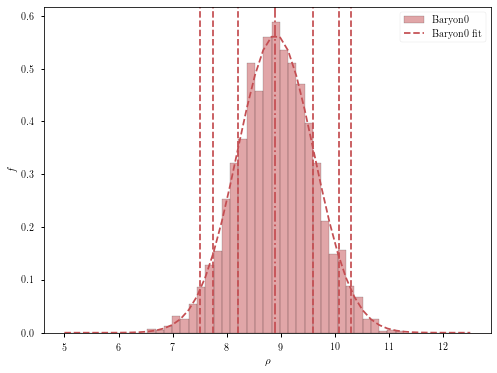

In [12]:
sigma = np.array([68, 90, 95]) # credible levels
alpha = np.round(1 - sigma/100, 2)

baryon_0 = {
    "fit": None,
    "errors": None,
    "mode": None,
}

# rhob_0_sample = np.random.choice(rhob_0, size=, replace=False)
rhob_0_fit = norm.fit(rhob_0)
baryon_0["fit"] = rhob_0_fit

rhob_0_errs = []
for i, alp in enumerate(alpha):
    hpd, modes = hdi(lambda x: norm.pdf(x, *rhob_0_fit), low=5, high=12.5, alpha=alp)
    low, high = hpd[0]
    baryon_0["mode"] = modes[0]
    err = {
        'alp': alp,
        'low': low,
        'high': high
    }
    rhob_0_errs.append(err)
# plot
rho = np.linspace(5, 12.5, 50)
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(rhob_0, bins=rho, density=True, label='Baryon0', ec='k', alpha=0.5, color='C2')
ax.plot(rho, norm.pdf(rho, *rhob_0_fit), label='Baryon0 fit', color='C2', ls='--')
ax.axvline(baryon_0['mode'], color='C2', ls='-.')

rhob_0_lows = list(map(lambda x: x['low'], rhob_0_errs))
rhob_0_highs = list(map(lambda x: x['high'], rhob_0_errs))
for low, high in zip(rhob_0_lows, rhob_0_highs):
    ax.axvline(low, color='C2', ls='--')
    ax.axvline(high, color='C2', ls='--')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$f$')
ax.legend()
print(f"rhob0 = {baryon_0['mode']:.02f} +{rhob_0_highs[0]-baryon_0['mode']:.3f}/-{baryon_0['mode'] - rhob_0_lows[0]:.3f}")

In [13]:
dms = []
baryons = []

for file in tqdm(files):
    dm = {
        "fit": None,
        "mode": None,
        "errors": None
    }
    baryon = {
        "fit": None,
        "mode": None,
        "errors": None
    }
    # load
    df = np.load(file)
    rhob = df[:, :, 12:24]
    rhob = rhob.reshape(-1, 12)
    rhob = rhob.sum(axis=1)/1E-2
    rho_dm = df[:, :, 24].reshape(-1)/1E-2
    # fit dm
    rho_dm_sample = np.random.choice(rho_dm, size=10_000, replace=False)
    rho_dm_fit = skewnorm.fit(rho_dm_sample)
    dm["fit"] = rho_dm_fit    
    # fit baryon
    rhob_sample = np.random.choice(rhob, size=10_000, replace=False)
    rhob_fit = skewnorm.fit(rhob_sample)
    baryon["fit"] = rhob_fit
    # err
    dm_errs = []
    baryon_errs = []
    dm_mode = None
    baryon_mode = None
    for i, alp in enumerate(alpha):
        hpd, modes = hdi(lambda x: skewnorm.pdf(x, *rho_dm_fit), -5, 10, alpha=alp)
        dm_mode = modes[0]
        low, high = hpd[0]
        dm_errs.append({'alpha': alp, 'low': low, 'high': high})

        hpd, modes = hdi(lambda x: skewnorm.pdf(x, *rhob_fit), 5, 15, alpha=alp)
        baryon_mode = modes[0]
        low, high = hpd[0]
        baryon_errs.append({'alpha': alp, 'low': low, 'high': high})
    dm["errors"] = dm_errs
    dm["mode"] = dm_mode
    baryon["errors"] = baryon_errs
    baryon["mode"] = baryon_mode
    # append
    dms.append(dm)
    baryons.append(baryon)


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


In [14]:
dms

[{'fit': (0.9545318832252682, 1.252835762188691, 1.0599916001089036),
  'mode': 1.78,
  'errors': [{'alpha': 0.32, 'low': 0.93, 'high': 2.68},
   {'alpha': 0.1, 'low': 0.38, 'high': 3.28},
   {'alpha': 0.05, 'low': 0.12, 'high': 3.58}]},
 {'fit': (4.77617379774227, 1.2241655606953827, 3.108185600991227),
  'mode': 2.41,
  'errors': [{'alpha': 0.32, 'low': 1.26, 'high': 4.77},
   {'alpha': 0.1, 'low': 0.74, 'high': 6.61},
   {'alpha': 0.05, 'low': 0.51, 'high': 7.49}]},
 {'fit': (6.736571804057165, 2.5235062723764368, 4.439924907992008),
  'mode': 3.9,
  'errors': [{'alpha': 0.32, 'low': 2.71, 'high': 6.96},
   {'alpha': 0.1, 'low': 2.29, 'high': 8.85},
   {'alpha': 0.05, 'low': 2.17, 'high': 9.5}]},
 {'fit': (1.9142122081000452, 5.169930212754787, 2.1167975110072392),
  'mode': 6.3,
  'errors': [{'alpha': 0.32, 'low': 5.03, 'high': 7.84},
   {'alpha': 0.1, 'low': 4.34, 'high': 8.92},
   {'alpha': 0.05, 'low': 4.06, 'high': 9.39}]},
 {'fit': (2.484738579762834, 5.800480624635638, 2.8580

(-5.0, 14.0)

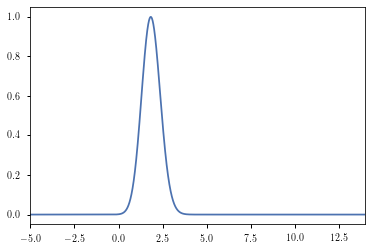

In [27]:
# calculate the combined values
# multiplying the rho_dm, but it became addition in log
rho = np.linspace(-5, 14, 10000)
log_rho_dm = None
rho_dm_fits = list(map(lambda x: x['fit'], dms))
for i, rho_dm_fit in enumerate(rho_dm_fits):
    # ignore F
    if (i > 0) and (i < 9):
        continue
    if log_rho_dm is None:
        log_rho_dm = skewnorm.logpdf(rho, *rho_dm_fit)
    else:
        log_rho_dm += skewnorm.logpdf(rho, *rho_dm_fit)
# normalize with max value
log_rho_dm -= log_rho_dm.max()
# turn into rho_dm
rho_dm_com = np.exp(log_rho_dm)
# plot
fig, ax = plt.subplots()
ax.plot(rho, rho_dm_com, label='rhoDM')
ax.set_xlim(-5,14)

(-5.0, 14.0)

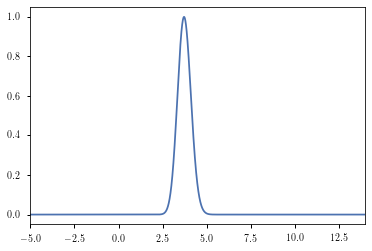

In [18]:
# calculate the combined values
# multiplying the rho_dm, but it became addition in log
rho = np.linspace(-5, 14, 10000)
log_rho_dm = None
weight = dc/dc.sum()
rho_dm_fits = list(map(lambda x: x['fit'], dms))
for i, (rho_dm_fit, w_i) in enumerate(zip(rho_dm_fits, weight)):
    # ignore F
    # if (i > 0) and (i < 9):
    #     continue
    if log_rho_dm is None:
        log_rho_dm = skewnorm.logpdf(rho, *rho_dm_fit)
    else:
        log_rho_dm += skewnorm.logpdf(rho, *rho_dm_fit)
# normalize with max value
log_rho_dm -= log_rho_dm.max()
# turn into rho_dm
rho_dm_com = np.exp(log_rho_dm)
# plot
fig, ax = plt.subplots()
ax.plot(rho, rho_dm_com, label='rho_dm')
ax.set_xlim(-5,14)

In [28]:
# fit with skewnorm
def skewpdf(x, *args):
    A, other = args[0], args[1:]
    return A*skewnorm.pdf(x, *other)

rho_dm_com_fit, _ = curve_fit(skewpdf, rho, rho_dm_com, p0=[1, 1.0, 2.0, 1])
rho_dm_com_fit

array([1.32763184, 0.81270872, 1.54287885, 0.61513178])

(-5.0, 14.0)

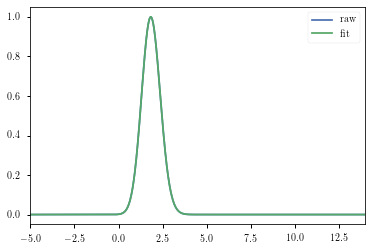

In [29]:
plt.plot(rho, rho_dm_com, label='raw')
plt.plot(rho, skewpdf(rho, *rho_dm_com_fit), label='fit', ls="-")
plt.legend()
plt.xlim(-5,14)

In [30]:
rho_dm_com_err = []
rho_dm_com_mode = None
for i, alp in enumerate(alpha):
    hpd, modes = hdi(lambda x: skewpdf(x, *rho_dm_com_fit), low=-5, high=15, alpha=alp, roundto=3)
    low, high = hpd[0]
    rho_dm_com_err.append({'sigma':sigma, 'low': low, 'high': high})
    rho_dm_com_mode = modes[0]
rho_dm_com_mode, rho_dm_com_err

(1.833,
 [{'sigma': array([68, 90, 95]), 'low': 1.313, 'high': 2.364},
  {'sigma': array([68, 90, 95]), 'low': 0.983, 'high': 2.724},
  {'sigma': array([68, 90, 95]), 'low': 0.823, 'high': 2.904}])

In [31]:
print(f"{rho_dm_com_mode:.3f} + {rho_dm_com_err[0]['high']-rho_dm_com_mode:.3f} - {rho_dm_com_mode-rho_dm_com_err[0]['low']:.3f}")

1.833 + 0.531 - 0.520


In [25]:
# spectral type boundaries
A9 = df_spec[df_spec['SpT'] == 'A9V']['J-K'].values[0]
F0 = df_spec[df_spec['SpT'] == 'F0V']['J-K'].values[0]
AF = (A9+F0)/2

F9 = df_spec[df_spec['SpT'] == 'F9V']['J-K'].values[0]
G0 = df_spec[df_spec['SpT'] == 'G0V']['J-K'].values[0]
FG = (F9+G0)/2
AF, FG

(0.1355, 0.314)

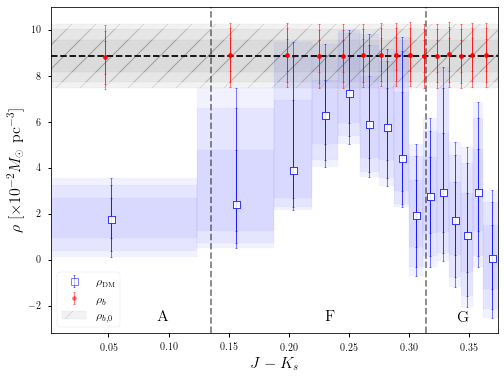

1.833

In [32]:
cs = np.linspace(c.min()-0.05, c.max()+0.005, 100)

def band(ax, c1, c2, low, high, color='blue', alpha=0.1):
    ax.fill_between([c1, c2], [low, low], [high, high], color=color, alpha=alpha)
    return 

fig, ax = plt.subplots(figsize=(8, 6))
ax.axhline(y=baryon_0['mode'], color='black', linestyle='--')
dm_errs = np.array(list(map(lambda x: x['errors'], dms)))
dm_modes = np.array(list(map(lambda x: x['mode'], dms)))
baryon_errs = np.array(list(map(lambda x: x['errors'], baryons)))
baryon_modes = np.array(list(map(lambda x: x['mode'], baryons)))

dm_errs[:, 0]
for i in range(3):
    lows = np.array(list(map(lambda x: x['low'], dm_errs[:, i])))
    highs = np.array(list(map(lambda x: x['high'], dm_errs[:, i])))

    dm_ax = ax.errorbar(c, dm_modes, yerr=[dm_modes-lows, highs-dm_modes], fmt='s', mfc='white', color='blue', capsize=1, alpha=0.5, elinewidth=1, markeredgewidth=1)
    for j in range(len(c)):
        band(ax, c_low[j], c_high[j], lows[j], highs[j], color='blue', alpha=0.05)

    lows = np.array(list(map(lambda x: x['low'], baryon_errs[:, i])))
    highs = np.array(list(map(lambda x: x['high'], baryon_errs[:, i])))
    rhob_ax = ax.errorbar(c-0.005, baryon_modes, yerr=[baryon_modes-lows, highs-baryon_modes], fmt='.', color='red', capsize=1, alpha=0.5, elinewidth=1, markeredgewidth=1)
    rhob_0_ax = ax.fill_between(cs, rhob_0_lows[i], rhob_0_highs[i], color='black', alpha=0.1, hatch="/", facecolor='gray')
    if i == 2:
        ax.legend([dm_ax, rhob_ax, rhob_0_ax], 
                  [r'$\rho_{\textup{\scriptsize DM}}$', r'$\rho_{b}$', r'$\rho_{b,0}$'],
                  loc='best', fontsize=12)
# real value
# ax.axhline(y=rhoDM_com_mode, color='black', linestyle='--')
ax.axvline(x=AF, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=FG, color='black', linestyle='--', alpha=0.5)
ax.text(0.09, -2.7, r'$\textup{A}$', fontsize=16)
ax.text(0.23, -2.7, r'$\textup{F}$', fontsize=16)
ax.text(0.34, -2.7, r'$\textup{G}$', fontsize=16)
ax.set_xlabel(r'$J-K_s$', fontsize=16)
ax.set_ylabel(r'$\rho$ [$\times 10^{-2}M_{\odot}\ $pc$^{-3}$]', fontsize=16)
ax.set_xlim(cs.min(), cs.max())
# ax.set_title("Dark matter \& baryonic density", fontsize=16)
fig.savefig(join('img', 'infered-density.pdf'), dpi=70)
plt.show()
rho_dm_com_mode

In [ ]:
# for i in range(len(c)):
#     low1 = np.array([err[0]['low'] for err in rhoDM_errs])
#     high1 = np.array([err[0]['high'] for err in rhoDM_errs])
#     low2 = np.array([err[1]['low'] for err in rhoDM_errs])
#     high2 = np.array([err[1]['high'] for err in rhoDM_errs])
#     low3 = np.array([err[2]['low'] for err in rhoDM_errs])
#     high3 = np.array([err[2]['high'] for err in rhoDM_errs])
#     print(f"$[{c1[i]:.03f}, {c2[i]:.03f}]$ & {rhoDM_modes[i]:.02f} & $[{low1[i]:.02f}, {high1[i]:.02f}]$ & $[{low2[i]:.02f}, {high2[i]:.02f}]$ & $[{low3[i]:.02f}, {high3[i]:.02f}]$ \\\\")